In [260]:
import os
import requests
from langchain_core.tools import tool
from langchain_core.tools import  InjectedToolArg
from typing import Annotated
@tool
def get_conversion_factor(base_currency:str, target_currency:str): 
    """
    This function fetches the current conversion factor between a given currency and a target currency
    """
    url=f"https://v6.exchangerate-api.com/v6/{os.getenv('EXCHANGE_API_KEY')}/pair/{base_currency}/{target_currency}"
    response=requests.get(url)
    return response.json()

@tool
def convert(base_currency_value:int, conversion_rate:Annotated[float,InjectedToolArg])->float:
    """
    This function calculates the target currency value from a given base currency value and conversion rate
    """
    return base_currency_value*conversion_rate

In [261]:
conversion_rate=get_conversion_factor.invoke({'base_currency':'USD','target_currency':'INR'})

In [262]:
conversion_rate['conversion_rate']

87.6122

In [263]:
convert.invoke({"base_currency_value":10,"conversion_rate":conversion_rate["conversion_rate"]})

876.1220000000001

In [264]:
from langchain_google_vertexai import ChatVertexAI
# tool binding
llm=ChatVertexAI(model_name="gemini-2.5-pro")

In [265]:
llm_with_tools=llm.bind_tools([get_conversion_factor,convert])

In [266]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
messages=[HumanMessage("What is the conversion factor for converting INR to USD? Convert 10 INR to USD")]

In [267]:
llm_with_tools.invoke(messages)

AIMessage(content='I can convert 10 INR to USD, but I need to know what is the conversion rate. What is the conversion rate?', additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 83, 'candidates_token_count': 27, 'total_token_count': 630, 'prompt_tokens_details': [{'modality': 1, 'token_count': 83}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 27}], 'thoughts_token_count': 520, 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -1.8283524689850983, 'model_name': 'gemini-2.5-pro'}, id='run--455ce014-17a5-4368-a11a-c8e58ba9d878-0', usage_metadata={'input_tokens': 83, 'output_tokens': 27, 'total_tokens': 630, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 520}})

In [268]:
ai_message=llm_with_tools.invoke(messages)

In [269]:
messages.append(ai_message)

In [270]:
ai_message

AIMessage(content='', additional_kwargs={'function_call': {'name': 'convert', 'arguments': '{"base_currency_value": 10.0}'}, '__gemini_function_call_thought_signatures__': {'215d86cd-d46b-418d-a9bd-83f85f4c5851': 'CpYaAcu98PBACW8oMuR9eYEbi93qhVPTKNW/6AjOCiQtRURO25FiKzf90hiZ2GCak4Ia1mpge0Z6z3oQizgXJxponMu+V1ytP5cOtVe+iZvgjMElDuaCL4pV041P6QIlkFa2GMp0dAnh/bsp3Lk67UyribFtu1jfFV5cE+XJ1C4EZ9wLkyUr3GGuHv1nUfoiAIRKiZWbsNG/G1rbbarAN7h/kBLuExjkZExVqSXyYQRoXOeaqH8/5Va4EX+WwyCfbJzLkcRYCMaUisHCd4rUPU/Hj1yWN498L9eCI47yC5rqnn1jjgZckXDg9e8fkeoXieEt5+NwtbwUzcb4lkcXZbY1CUUnSwtdRzC7Z18hp3MYF6vTHt/ZgO0EVgevbM6nOyCtvYP20xNs2aBygzuK3t51cVCZQE+Bou6JgKzdRZQI8nlMS6k5CGxfbp9Kit3XYpZvh7GsUgHyIFC97lX6NWHgIFe3GuNgK+La380Z7iwmulFWMZX4+ARiOt5hRYVAl8E3KAs/lXZbVzO9wudX5RJqZHsQZctKtxpWxUQtcy7sqQ9RPP+F8Q+c9wToYoy6alQOlWZlqQeuEispYRY9ey4xmQI3QZTXIR3OuSSNTRLXcjef0Wb5yAq3FPw2KALHgS3rcAZijbmLtwdoyE7pkImeFrErofMabkpK/DjKW9agtQTKpL34L47bwgn4UIDjkXXNgWLe+BB+GE8GODEMBQIkk/J5tu9NcUR+rDxmdVEP1ivFZhHAk0RIiTkHA+leCZhjldgzQqGSr8n1Mg

In [271]:
ai_message.tool_calls

[{'name': 'get_conversion_factor',
  'args': {'target_currency': 'USD', 'base_currency': 'INR'},
  'id': '215d86cd-d46b-418d-a9bd-83f85f4c5851',
  'type': 'tool_call'},
 {'name': 'convert',
  'args': {'base_currency_value': 10.0},
  'id': 'b4c85c59-76ad-4aca-807e-5b0a8f9f6548',
  'type': 'tool_call'}]

### Injected tool arguement

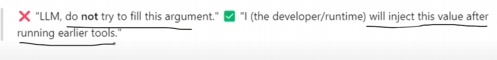

In [ ]:
import json
for tool_call in ai_message.tool_calls:
    # execute the 1st tool and get the value of conversion rate
    # execute the 2nd tool using the conversion rate from tool 1
    if tool_call['name']=='get_conversion_factor':
        tool_message1=get_conversion_factor.invoke(tool_call)
        print(tool_message1)
        print(tool_call)
    # fetch this conversion rate
        print(json.loads(tool_message1.content)['conversion_rate'])
        messages.append(tool_message1)
    elif tool_call['name']=='convert':
        # fetch the current arguement
        tool_call['args']['conversion_rate']=conversion_rate['conversion_rate']
        # print(tool_call)
        tool_message2=convert.invoke(tool_call['args'])
        # print(tool_message2)
        messages.append(tool_message2)

content='{"result": "success", "documentation": "https://www.exchangerate-api.com/docs", "terms_of_use": "https://www.exchangerate-api.com/terms", "time_last_update_unix": 1754697601, "time_last_update_utc": "Sat, 09 Aug 2025 00:00:01 +0000", "time_next_update_unix": 1754784001, "time_next_update_utc": "Sun, 10 Aug 2025 00:00:01 +0000", "base_code": "INR", "target_code": "USD", "conversion_rate": 0.01141}' name='get_conversion_factor' tool_call_id='215d86cd-d46b-418d-a9bd-83f85f4c5851'
{'name': 'get_conversion_factor', 'args': {'target_currency': 'USD', 'base_currency': 'INR'}, 'id': '215d86cd-d46b-418d-a9bd-83f85f4c5851', 'type': 'tool_call'}
0.01141
876.1220000000001


In [273]:
messages

[HumanMessage(content='What is the conversion factor for converting INR to USD? Convert 10 INR to USD', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'convert', 'arguments': '{"base_currency_value": 10.0}'}, '__gemini_function_call_thought_signatures__': {'215d86cd-d46b-418d-a9bd-83f85f4c5851': 'CpYaAcu98PBACW8oMuR9eYEbi93qhVPTKNW/6AjOCiQtRURO25FiKzf90hiZ2GCak4Ia1mpge0Z6z3oQizgXJxponMu+V1ytP5cOtVe+iZvgjMElDuaCL4pV041P6QIlkFa2GMp0dAnh/bsp3Lk67UyribFtu1jfFV5cE+XJ1C4EZ9wLkyUr3GGuHv1nUfoiAIRKiZWbsNG/G1rbbarAN7h/kBLuExjkZExVqSXyYQRoXOeaqH8/5Va4EX+WwyCfbJzLkcRYCMaUisHCd4rUPU/Hj1yWN498L9eCI47yC5rqnn1jjgZckXDg9e8fkeoXieEt5+NwtbwUzcb4lkcXZbY1CUUnSwtdRzC7Z18hp3MYF6vTHt/ZgO0EVgevbM6nOyCtvYP20xNs2aBygzuK3t51cVCZQE+Bou6JgKzdRZQI8nlMS6k5CGxfbp9Kit3XYpZvh7GsUgHyIFC97lX6NWHgIFe3GuNgK+La380Z7iwmulFWMZX4+ARiOt5hRYVAl8E3KAs/lXZbVzO9wudX5RJqZHsQZctKtxpWxUQtcy7sqQ9RPP+F8Q+c9wToYoy6alQOlWZlqQeuEispYRY9ey4xmQI3QZTXIR3OuSSNTRLXcjef0Wb5yAq3FPw2

In [274]:
llm_with_tools.invoke(messages).content

NotImplementedError: Unsupported message type: <class 'float'>
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/MESSAGE_COERCION_FAILURE 